## Task 2 - CLIP Fine-Tuning on the Visual Encoder

In [1]:
#@title GPU / Python / Torch sanity
import os, sys, subprocess, json, platform, torch
print("Python :", sys.version)
print("CUDA   :", torch.version.cuda)
print("Torch  :", torch.__version__)
print("Device :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
!nvidia-smi || true

Python : 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
CUDA   : 12.1
Torch  : 2.3.1+cu121
Device : NVIDIA GeForce RTX 4090
Tue Nov 11 19:07:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
| 35%   49C    P3             39W /  450W |     152MiB /  24564MiB |      0%

In [2]:
# some imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from transformers import CLIPProcessor, CLIPModel, AutoProcessor, CLIPVisionModel, logging
import clip
from peft import LoraConfig, get_peft_model, TaskType
from torchinfo import summary
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import json
import warnings
import gc, torch
import torch.nn.functional as F
from PIL import Image
import os
from datasets import load_dataset
import io
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
from pathlib import Path

import pandas as pd


def save_training_artifacts(prefix: str, title: str, train_losses, train_accuracies, val_losses=None, val_accuracies=None):
    if not train_losses:
        return
    epochs = list(range(1, len(train_losses) + 1))
    data = {
        "epoch": epochs,
        "train_loss": train_losses,
        "train_accuracy": train_accuracies,
    }
    if val_losses is not None and len(val_losses) == len(epochs):
        data["val_loss"] = val_losses
    if val_accuracies is not None and len(val_accuracies) == len(epochs):
        data["val_accuracy"] = val_accuracies
    os.makedirs("data", exist_ok=True)
    csv_path = os.path.join("data", f"{prefix}.csv")
    pd.DataFrame(data).to_csv(csv_path, index=False)
    fig = None
    try:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].plot(epochs, train_losses, label="train")
        if val_losses is not None and len(val_losses) == len(epochs):
            axes[0].plot(epochs, val_losses, label="val")
        axes[0].set_title("Loss")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].legend()

        axes[1].plot(epochs, train_accuracies, label="train")
        if val_accuracies is not None and len(val_accuracies) == len(epochs):
            axes[1].plot(epochs, val_accuracies, label="val")
        axes[1].set_title("Accuracy")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].legend()

        fig.suptitle(title)
        fig.tight_layout()
        fig.savefig(os.path.join("data", f"{prefix}.png"))
        plt.show()
    except Exception:
        pass
    finally:
        if fig is not None:
            plt.close(fig)


/home/abat/conda_envs/clip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 降噪：避免 tokenizers 在多工情境下噴警告
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# some settings
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "openai/clip-vit-large-patch14" # pre-trained CLIP model (ViT-L/14)
LINEAR_BATCH_SIZE = 1024 # adjust based on your GPU memory
FINE_BATCH_SIZE   = 16  # adjust based on your GPU memory
NUM_WORKERS = 8
# For Linear Probe & LoRA
NUM_EPOCHS = 30
print(f"Using device: {DEVICE}")


processor = CLIPProcessor.from_pretrained(MODEL_ID)
model     = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
model.eval()




Using device: cuda


/home/abat/conda_envs/clip/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [4]:
# ==== Flowers102 (torchvision) ====


# 把 PIL 影像轉成 (3,224,224) 的 CLIP 規格 tensor
def clip_image_transform(image):
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    image = image.convert("RGB")
    px = processor(images=image, return_tensors="pt")["pixel_values"][0]  # (3,224,224)
    return px

flowers102_test_dts = Flowers102(
    root="./data",
    split="test",
    transform=clip_image_transform,
    download=True
)
flowers102_train_dts = Flowers102(
    root="./data",
    split="train",
    transform=clip_image_transform,
    download=True
)

# validation split for Flowers102 (torchvision provides 'val' split)
flowers102_val_dts = Flowers102(
    root="./data",
    split="val",
    transform=clip_image_transform,
    download=True
)
print(f"Total test samples (Flowers102): {len(flowers102_test_dts)}")  # 6149

flowers102_train_loader = DataLoader(
    flowers102_train_dts,
    batch_size=LINEAR_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

flowers102_val_loader = DataLoader(
    flowers102_val_dts,
    batch_size=LINEAR_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

flowers102_test_loader = DataLoader(
    flowers102_test_dts,
    batch_size=LINEAR_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# 類別名稱（使用你上傳的 cat_to_name.json）
with open("./data/cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)
flowers102_class_names = [cat_to_name[str(i)] for i in range(1, 103)]


Total test samples (Flowers102): 6149


In [5]:
# ==== CUB-200-2011 (HF datasets) ====

birds_200 = load_dataset("bentrevett/caltech-ucsd-birds-200-2011", cache_dir="./data")
cub_bird_test_raw = birds_200["test"]
cub_bird_train_raw = birds_200["train"]
# build a small validation split from training set (10%)
cub_bird_train_raw = cub_bird_train_raw
cub_bird_train_raw, cub_bird_val_raw = cub_bird_train_raw.train_test_split(test_size=0.1, seed=42).values()
print(f"Total train/val/test samples (CUB): {len(cub_bird_train_raw)}/{len(cub_bird_val_raw)}/{len(cub_bird_test_raw)}")

def _to_pil_image_safe(img):
    """Robust convert HF dataset image (PIL/ndarray/list/bytes) -> PIL.Image."""
    if isinstance(img, Image.Image):
        return img
    if isinstance(img, np.ndarray):
        return Image.fromarray(img)
    # list may be list-of-ints (bytes) or nested lists (HWC)
    if isinstance(img, (list, tuple)):
        # list of ints -> bytes
        if all(isinstance(x, (int, np.integer)) for x in img):
            return Image.open(io.BytesIO(bytes(img)))
        # else try to convert to array (may raise ValueError for ragged)
        try:
            arr = np.asarray(img, dtype=np.uint8)
            return Image.fromarray(arr)
        except Exception as ex:
            raise TypeError(f"Cannot convert list image to PIL (ragged?): {ex}") from ex
    if isinstance(img, (bytes, bytearray)):
        return Image.open(io.BytesIO(img))
    raise TypeError(f"Unsupported image type for conversion to PIL: {type(img)}")

def cub_transform(example):
    """
    Accept both single example and batch-dict (where example['image'] is a list).
    Return pixel_values as numpy arrays (C,H,W) to keep HF formatting/collate stable.
    """
    def proc_one(img):
        pil = _to_pil_image_safe(img).convert("RGB")
        px = processor(images=pil, return_tensors="pt")["pixel_values"][0]  # tensor (3,224,224)
        return px.numpy()

    # batched call from datasets.formatting may pass lists
    if isinstance(example, dict) and isinstance(example.get("image"), (list, tuple)):
        imgs = [proc_one(im) for im in example["image"]]
        labs = list(example["label"])
        return {"pixel_values": imgs, "label": labs}
    # single example
    img = example["image"]
    px_arr = proc_one(img)
    return {"pixel_values": px_arr, "label": example["label"]}

cub_bird_train_dts = cub_bird_train_raw.with_transform(cub_transform)
cub_bird_val_dts = cub_bird_val_raw.with_transform(cub_transform)
cub_bird_test_dts = cub_bird_test_raw.with_transform(cub_transform)

# 強韌的 collate：把所有樣本疊成 (B,3,224,224)，label 成 (B,)
def _to_chw224(x: torch.Tensor) -> torch.Tensor:
    x = torch.as_tensor(x)
    if not torch.is_floating_point(x):
        x = x.float() / 255.0
    if x.ndim == 3:
        # HWC -> CHW
        if x.shape[-1] == 3 and x.shape[0] != 3:
            x = x.permute(2, 0, 1)
        # 灰階擴通道
        if x.shape[0] == 1:
            x = x.repeat(3, 1, 1)
        elif x.shape[0] != 3:
            raise ValueError(f"Unexpected channel dim: {x.shape}")
    elif x.ndim == 2:
        x = x.unsqueeze(0).repeat(3, 1, 1)
    else:
        raise ValueError(f"Unexpected ndim {x.ndim} for image with shape {tuple(x.shape)}")
    if x.shape[1:] != (224, 224):
        x = F.interpolate(x.unsqueeze(0).float(), size=(224, 224),
                          mode="bilinear", align_corners=False).squeeze(0)
    return x.float()

def hf_collate_fn(batch):
    imgs = torch.stack([_to_chw224(b["pixel_values"]) for b in batch], dim=0)  # (B,3,224,224)
    labs = torch.tensor([int(b["label"]) for b in batch], dtype=torch.long)    # (B,)
    return {"pixel_values": imgs, "label": labs}

from torch.utils.data import DataLoader
cub_bird_train_loader = DataLoader(
    cub_bird_train_dts,
    batch_size=LINEAR_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=hf_collate_fn
)

cub_bird_val_loader = DataLoader(
    cub_bird_val_dts,
    batch_size=LINEAR_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=hf_collate_fn
)

cub_bird_test_loader = DataLoader(
    cub_bird_test_dts,
    batch_size=LINEAR_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=hf_collate_fn
)

# 類別名稱由 HF features 提供
cub_bird_class_names = cub_bird_test_raw.features["label"].names

import re
def clean_cub_name(name: str) -> str:
    name = re.sub(r'^\d+\.', '', name)   # remove leading numeric prefix
    name = name.replace('_', ' ')
    return name.strip()

cub_bird_class_names = [clean_cub_name(n) for n in cub_bird_class_names]
for x in cub_bird_class_names[:10]:
    print(x)

Total train/val/test samples (CUB): 5394/600/5794
Black footed Albatross
Laysan Albatross
Sooty Albatross
Groove billed Ani
Crested Auklet
Least Auklet
Parakeet Auklet
Rhinoceros Auklet
Brewer Blackbird
Red winged Blackbird


In [6]:

# 工具函式：比較原始 CLIP 與訓練後模型的預測
from typing import Any, Dict, List, Optional, Sequence, Tuple
import math

DATASET_REGISTRY: Dict[str, Dict[str, Any]] = {
    "flowers102": {
        "splits": {
            "train": flowers102_train_dts,
            "val": flowers102_val_dts,
            "test": flowers102_test_dts,
        },
        "class_names": flowers102_class_names,
    },
    "cub_bird": {
        "splits": {
            "train": cub_bird_train_dts,
            "val": cub_bird_val_dts,
            "test": cub_bird_test_dts,
        },
        "class_names": cub_bird_class_names,
    },
}

for entry in DATASET_REGISTRY.values():
    entry["prompts"] = [f"a photo of a {name}" for name in entry["class_names"]]

TRAINED_VARIANTS: Dict[str, Dict[str, Any]] = {}

def save_trained_variant_to_disk(variant_name: str, base_dir: str = "./saved_variants"):
    """保存 TRAINED_VARIANTS[variant_name] 的 backbone 與 head 到磁碟（HF format + head state_dict）。"""
    variant = TRAINED_VARIANTS.get(variant_name)
    if variant is None:
        raise KeyError(f"Variant '{variant_name}' not found in TRAINED_VARIANTS.")
    out = Path(base_dir) / variant_name
    out.mkdir(parents=True, exist_ok=True)

    backbone = variant["backbone"]
    head = variant["head"]

    # try HF-style save first
    try:
        backbone.save_pretrained(str(out / "backbone"))
    except Exception:
        try:
            torch.save(backbone.state_dict(), str(out / "backbone_state.pth"))
        except Exception as e:
            print("Warning: failed to save backbone with both save_pretrained and state_dict:", e)

    try:
        torch.save(head.state_dict(), str(out / "head_state.pth"))
    except Exception as e:
        print("Warning: failed to save head state_dict:", e)

    meta = {
        "dataset": variant.get("dataset"),
        "notes": variant.get("notes", ""),
    }
    with open(out / "meta.json", "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)
    print(f"Saved variant '{variant_name}' to {out}")
    
def load_trained_variant_from_disk(variant_name: str, base_dir: str = "./saved_variants", device: str = None):
    """從磁碟載入 previously-saved variant。回傳 (backbone, head). device 可為 'cpu' 或 'cuda' 等。"""
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    base = Path(base_dir) / variant_name
    if not base.exists():
        raise FileNotFoundError(f"No saved variant at {base}")

    backbone = None
    # prefer HF-style dir
    hf_dir = base / "backbone"
    if hf_dir.exists():
        backbone = CLIPModel.from_pretrained(str(hf_dir)).to(device)
    else:
        # try load state_dict into fresh model from pretrained MODEL_ID
        if (base / "backbone_state.pth").exists():
            backbone = CLIPModel.from_pretrained(MODEL_ID).to(device)
            state = torch.load(str(base / "backbone_state.pth"), map_location="cpu")
            try:
                backbone.load_state_dict(state, strict=False)
            except Exception:
                # best-effort
                pass
            backbone.to(device)
        else:
            raise FileNotFoundError("No backbone checkpoint found in saved variant.")

    # rebuild head by running a dummy forward to get feat_dim
    with torch.no_grad():
        dummy_px = processor(images=Image.new("RGB", (224, 224), "white"), return_tensors="pt")["pixel_values"].to(device)
        feat = backbone.get_image_features(pixel_values=dummy_px)
        feat_dim = feat.shape[-1]
    # try to load saved head
    head = nn.Linear(feat_dim, feat_dim)  # placeholder, will be replaced by correct size when loading
    head_path = base / "head_state.pth"
    if head_path.exists():
        # load dict to infer out_features if possible
        st = torch.load(str(head_path), map_location="cpu")
        # attempt to infer out_features from saved state keys (Linear: weight shape = [out_features, in_features])
        if "weight" in st:
            w = st["weight"]
            out_f, in_f = w.shape
            head = nn.Linear(in_f, out_f).to(device)
            head.load_state_dict(st)
        else:
            # fallback: try original behaviour — recreate typical classifier sized to known dataset if available
            # create linear feat_dim -> num_classes if we can infer dataset from meta
            meta_path = base / "meta.json"
            num_classes = None
            if meta_path.exists():
                try:
                    m = json.load(open(meta_path, "r", encoding="utf-8"))
                    ds = m.get("dataset")
                    if ds in DATASET_REGISTRY:
                        num_classes = len(DATASET_REGISTRY[ds]["class_names"])
                except Exception:
                    pass
            if num_classes is None:
                raise RuntimeError("Cannot infer head shape; please recreate head manually before saving.")
            head = nn.Linear(feat_dim, num_classes).to(device)
            head.load_state_dict(st)
    else:
        raise FileNotFoundError("No head_state.pth found for this variant.")

    head.to(device)
    backbone.to(device)
    backbone.eval(); head.eval()
    return backbone, head

def _extract_sample(sample):
    if isinstance(sample, dict):
        pixels = sample["pixel_values"]
        label = sample.get("label")
    else:
        pixels, label = sample
    px = torch.as_tensor(pixels).float()
    if px.ndim == 4:
        px = px.squeeze(0)
    if px.ndim == 3 and px.shape[0] not in (1, 3) and px.shape[-1] == 3:
        px = px.permute(2, 0, 1)
    if px.ndim == 2:
        px = px.unsqueeze(0)
    if px.shape[0] == 1:
        px = px.repeat(3, 1, 1)
    if px.shape[1:] != (224, 224):
        px = F.interpolate(
            px.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False
        ).squeeze(0)
    if px.ndim != 3 or px.shape[0] != 3:
        raise ValueError(f"Unexpected pixel shape: {tuple(px.shape)}")
    return px, (int(label) if label is not None else None)


def _prepare_batch(dataset_obj, indices: Sequence[int]):
    tensors: List[torch.Tensor] = []
    labels: List[Optional[int]] = []
    actual_indices: List[int] = []
    for idx in indices:
        if idx < 0 or idx >= len(dataset_obj):
            raise IndexError(f"Index {idx} out of range for dataset length {len(dataset_obj)}")
        sample = dataset_obj[idx]
        px, label = _extract_sample(sample)
        tensors.append(px)
        labels.append(label)
        actual_indices.append(idx)
    batch = torch.stack(tensors, dim=0)
    return batch, labels, actual_indices

def _resolve_dataset(dataset_name: str, split: str):
    if dataset_name not in DATASET_REGISTRY:
        raise ValueError(f"Unknown dataset '{dataset_name}'.")
    info = DATASET_REGISTRY[dataset_name]
    if split not in info["splits"]:
        raise ValueError(f"Dataset '{dataset_name}' has no split '{split}'.")
    return info["splits"][split], info["class_names"], info["prompts"]


def free_gpu_safe(offload_registered: bool = True, skip_registered: bool = False):
    """
    較保險的 GPU 清理：
      - 若 offload_registered=True，會把 TRAINED_VARIANTS 中的 backbone/head/baseline 移到 CPU（保留 references）。
      - 若 skip_registered=True，完全不 touch TRAINED_VARIANTS（適合你想避免清理的情況）。
    """
    if not skip_registered:
        try:
            for v in TRAINED_VARIANTS.values():
                for key in ("backbone", "head", "baseline"):
                    obj = v.get(key)
                    if obj is None:
                        continue
                    try:
                        if offload_registered and hasattr(obj, "to"):
                            obj.to("cpu")
                        if hasattr(obj, "eval"):
                            obj.eval()
                        for p in getattr(obj, "parameters", lambda: [])() or []:
                            p.requires_grad = False
                    except Exception:
                        pass
        except NameError:
            pass

    # 刪除常見臨時變數（但不刪除 TRAINED_VARIANTS 內的物件）
    for name in ("head", "optimizer", "model_lora", "vision_model_lora", "model_fb"):
        if name in globals():
            try:
                del globals()[name]
            except Exception:
                pass

    gc.collect()
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.synchronize()

Visualization

In [7]:



def register_trained_variant(
    name: str,
    dataset: str,
    backbone: "CLIPModel",
    head: nn.Module,
    baseline: Optional["CLIPModel"] = None,
    notes: Optional[str] = None,
    save_to_disk: bool = True,
) -> None:
    """紀錄訓練後的模型組態，供可視化比較使用。"""
    baseline_model = baseline if baseline is not None else model
    backbone.eval()
    head.to(next(backbone.parameters()).device)
    head.eval()
    baseline_model.eval()
    TRAINED_VARIANTS[name] = {
        "dataset": dataset,
        "backbone": backbone,
        "head": head,
        "baseline": baseline_model,
        "notes": notes or "",
    }
    print(f"Registered variant '{name}' (dataset={dataset}).")
    if save_to_disk:
        try:
            save_trained_variant_to_disk(name)
        except Exception as e:
            print(f"Warning: failed saving variant '{name}' to disk: {e}")


def save_prediction_comparison_grid(
    variant_name: str,
    dataset: str,
    *,
    num_images: int,
    indices: Sequence[int],
    split: str = "test",
    cols: int = 3,
    top_k: int = 3,
    font_size: int = 9,
    output_path: Optional[str] = None,
    show: bool = False,
    device: Optional[str] = None,  # 新增：可指定載入/執行的 device (e.g. "cuda"/"cpu")
) -> None:
    """產生原始 CLIP 與訓練後模型的比較圖，並儲存於指定路徑。

    行為改動：
    - 若 TRAINED_VARIANTS 中找不到 variant，會嘗試從 ./saved_variants 裡載入 (使用 load_trained_variant_from_disk)。
    - 可用 device 參數強制把模型移到指定裝置。
    """
    # 嘗試取得註冊的 variant；若不存在則嘗試從磁碟載入
    variant = TRAINED_VARIANTS.get(variant_name)
    if variant is None:
        try:
            tgt = device or ("cuda" if torch.cuda.is_available() else "cpu")
            backbone_loaded, head_loaded = load_trained_variant_from_disk(variant_name, device=tgt)
            # 將載入的模型註冊到 TRAINED_VARIANTS，baseline 使用全域 model（zero-shot）
            TRAINED_VARIANTS[variant_name] = {
                "dataset": dataset,
                "backbone": backbone_loaded,
                "head": head_loaded,
                "baseline": model,
                "notes": "",
            }
            variant = TRAINED_VARIANTS[variant_name]
            print(f"Loaded variant '{variant_name}' from disk into TRAINED_VARIANTS (device={tgt}).")
        except Exception as e:
            print(f"Variant '{variant_name}' 尚未建立且無法從磁碟載入：{e}")
            return

    dataset_obj, class_names, prompts = _resolve_dataset(dataset, split)
    if len(dataset_obj) == 0:
        print(f"Dataset '{dataset}' ({split}) is empty.")
        return

    if num_images <= 0:
        raise ValueError("num_images 必須大於 0")
    if indices is None or len(indices) == 0:
        raise ValueError("indices 至少需要一個項目")

    selected_indices = list(indices)[:num_images]
    pixel_batch, labels, actual_indices = _prepare_batch(dataset_obj, selected_indices)

    backbone = variant["backbone"]
    head = variant["head"]
    baseline_model = variant.get("baseline", model)

    # 如果使用者指定 device，強制移動模型至該裝置
    if device is None:
        # 預設 device 為 backbone 目前所在裝置（若可取得 parameter）
        try:
            default_dev = next(backbone.parameters()).device
            device = str(default_dev)
        except Exception:
            device = ("cuda" if torch.cuda.is_available() else "cpu")

    device = torch.device(device)
    pixel_batch = pixel_batch.to(device)

    with torch.no_grad():
        baseline_model = baseline_model.to(device)
        backbone = backbone.to(device)
        head = head.to(device)

        baseline_model.eval()
        backbone.eval()
        head.eval()

        text_inputs = processor(text=prompts, return_tensors="pt", padding=True)
        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
        text_features = baseline_model.get_text_features(**text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        image_features_orig = baseline_model.get_image_features(
            pixel_values=pixel_batch.to(baseline_model.dtype)
        )
        image_features_orig = image_features_orig / image_features_orig.norm(dim=-1, keepdim=True)
        logits_orig = image_features_orig @ text_features.T
        probs_orig = logits_orig.softmax(dim=-1)

        image_features_trained = backbone.get_image_features(
            pixel_values=pixel_batch.to(backbone.dtype)
        )
        image_features_trained = image_features_trained / image_features_trained.norm(dim=-1, keepdim=True)
        head_params = list(head.parameters())
        head_dtype = head_params[0].dtype if head_params else image_features_trained.dtype
        image_features_trained = image_features_trained.to(head_dtype)
        logits_trained = head(image_features_trained)
        probs_trained = logits_trained.softmax(dim=-1)

    top_k = max(1, min(top_k, len(class_names)))
    orig_vals, orig_idx = torch.topk(probs_orig, top_k, dim=1)
    tr_vals, tr_idx = torch.topk(probs_trained, top_k, dim=1)

    rows = math.ceil(num_images / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.2, rows * 3.2), constrained_layout=True)
    # 調整子圖間距（改成較小的間距）。如要更緊密，調小 wspace/hspace（例如 0.15, 0.18）
    fig.subplots_adjust(wspace=0.18, hspace=0.28)

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    axes = axes.flatten()

    label_tensor = torch.tensor([(-1 if l is None else l) for l in labels])

    for i, idx in enumerate(actual_indices):
        ax = axes[i]
        ax.axis("off")

        img = pixel_batch[i].detach().float().cpu()
        img = (img - img.min()) / max(1e-6, (img.max() - img.min()))
        ax.imshow(img.permute(1, 2, 0))

        gt = label_tensor[i].item()
        if 0 <= gt < len(class_names):
            title = f"idx:{idx} GT: {class_names[gt]}"
        else:
            title = f"idx:{idx} GT: N/A"
        ax.set_title(title, fontsize=font_size + 1, pad=3)

        # 改為上下排列：Zero-shot 在上方，Trained 在下方
        text_x = 1.02
        top_y = 0.92
        dy = 0.085  # 每列文字垂直間距；可改小以擠更多行（但太小會重疊）
        # 計算 trained header 的起始 y（在 zero-shot 之下）
        trained_header_y = top_y - (top_k + 1) * dy - 0.06

        ax.text(text_x, top_y, "Zero-shot", transform=ax.transAxes, fontsize=font_size, fontweight="bold", ha="left", va="top")
        # 列出 zero-shot 預測
        for rank in range(top_k):
            b_idx = int(orig_idx[i, rank])
            b_score = float(orig_vals[i, rank]) * 100.0
            base_color = "#23a559" if b_idx == gt and gt >= 0 else "#d43f3a"
            ax.text(
                text_x,
                top_y - (rank + 1) * dy,
                f"{rank + 1}. {class_names[b_idx]} ({b_score:.1f}%)",
                transform=ax.transAxes,
                fontsize=font_size,
                color=base_color,
                ha="left",
                va="top",
            )

        # Trained header & 列表（放在 zero-shot 之下）
        ax.text(text_x, trained_header_y, "Trained", transform=ax.transAxes, fontsize=font_size, fontweight="bold", ha="left", va="top")
        for rank in range(top_k):
            t_idx = int(tr_idx[i, rank])
            t_score = float(tr_vals[i, rank]) * 100.0
            trained_color = "#23a559" if t_idx == gt and gt >= 0 else "#d43f3a"
            ax.text(
                text_x,
                trained_header_y - (rank + 1) * dy,
                f"{rank + 1}. {class_names[t_idx]} ({t_score:.1f}%)",
                transform=ax.transAxes,
                fontsize=font_size,
                color=trained_color,
                ha="left",
                va="top",
            )
        

    for j in range(len(actual_indices), len(axes)):
        axes[j].axis("off")

    if output_path is None:
        output_path = f"./data/{variant_name}_{dataset}_result.png"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    fig.savefig(output_path, dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)
    print(f"Saved comparison grid to {output_path}")



In [ ]:

print("--- Starting Method: Linear Probing Flowers ---")

# We'll use the existing CLIP model (loaded earlier) and attach a linear classifier on top of image features.
# Get image feature dimension with a dummy forward
with torch.no_grad():
    dummy_px = processor(images=Image.new("RGB", (224, 224), "white"), return_tensors="pt")["pixel_values"].to(DEVICE)
    feat = model.get_image_features(pixel_values=dummy_px)
    feat_dim = feat.shape[-1]

# Freeze full vision encoder to perform linear probing
vision_model = model.vision_model
visual_projection = getattr(model, 'visual_projection', None)
for p in vision_model.parameters():
    p.requires_grad = False
if visual_projection is not None:
    for p in visual_projection.parameters():
        p.requires_grad = False

# Simple linear head
def make_head(num_classes):
    return nn.Linear(feat_dim, num_classes).to(DEVICE)

num_classes = len(flowers102_class_names)
train_loader = flowers102_train_loader if 'flowers102_train_loader' in globals() else None
val_loader = flowers102_val_loader if 'flowers102_val_loader' in globals() else None
test_loader = flowers102_test_loader if 'flowers102_test_loader' in globals() else None
class_names = flowers102_class_names

head = make_head(num_classes)

# training setup
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.Adam(head.parameters(), lr=lr)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

from time import time

def evaluate(loader):
    head.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, dict):
                imgs, labels = batch['pixel_values'], batch['label']
            else:
                imgs, labels = batch
            if isinstance(imgs, list):
                imgs = torch.stack(imgs, dim=0)
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            feats = model.get_image_features(pixel_values=imgs)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            logits = head(feats)
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loss_sum += loss.item() * labels.size(0)
    return loss_sum / total, correct / total

# If no training loader is available, skip training and just run evaluation on test set
if train_loader is None:
    print('No training loader prepared for the chosen dataset; running evaluation on test set only')
    test_loss, test_acc = evaluate(test_loader)
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
else:
    # training loop
    for epoch in range(NUM_EPOCHS):
        head.train()
        epoch_start = time()
        running_loss = 0.0
        running_correct = 0
        seen = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
            if isinstance(batch, dict):
                imgs, labels = batch['pixel_values'], batch['label']
            else:
                imgs, labels = batch
            if isinstance(imgs, list):
                imgs = torch.stack(imgs, dim=0)
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            feats = model.get_image_features(pixel_values=imgs)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            logits = head(feats)
            preds = logits.argmax(dim=-1)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            running_correct += (preds == labels).sum().item()
            seen += labels.size(0)

        train_loss = running_loss / max(1, seen)
        train_acc = running_correct / max(1, seen)
        if val_loader is not None:
            val_loss, val_acc = evaluate(val_loader)
        else:
            val_loss, val_acc = evaluate(test_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        epoch_end = time()
        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Time: {epoch_end-epoch_start:.2f}s")

    save_training_artifacts("linear_flowers", "Linear Probing Flowers", train_losses, train_accuracies, val_losses, val_accuracies)

    # final test
    test_loss, test_acc = evaluate(test_loader)
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

register_trained_variant(
    name="linear_flowers",
    dataset="flowers102",
    backbone=model,
    head=head,
    baseline=model,
    notes="Linear probing on Flowers102"
)
print('Linear probing Flowers finished')



--- Starting Method: Linear Probing Flowers ---


Epoch 1/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.36s/it]


Epoch 1 - Train Loss: 4.6257 | Train Acc: 0.69% | Val Loss: 4.6172 | Val Acc: 1.86% | Time: 18.59s


Epoch 2/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.05s/it]


Epoch 2 - Train Loss: 4.6169 | Train Acc: 2.35% | Val Loss: 4.6089 | Val Acc: 4.12% | Time: 18.06s


Epoch 3/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.01s/it]


Epoch 3 - Train Loss: 4.6080 | Train Acc: 5.10% | Val Loss: 4.6007 | Val Acc: 8.14% | Time: 18.02s


Epoch 4/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.03s/it]


Epoch 4 - Train Loss: 4.5991 | Train Acc: 9.12% | Val Loss: 4.5925 | Val Acc: 14.90% | Time: 18.05s


Epoch 5/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.04s/it]


Epoch 5 - Train Loss: 4.5903 | Train Acc: 16.47% | Val Loss: 4.5843 | Val Acc: 22.94% | Time: 18.09s


Epoch 6/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.04s/it]


Epoch 6 - Train Loss: 4.5814 | Train Acc: 26.67% | Val Loss: 4.5760 | Val Acc: 32.16% | Time: 18.06s


Epoch 7/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.07s/it]


Epoch 7 - Train Loss: 4.5726 | Train Acc: 36.57% | Val Loss: 4.5678 | Val Acc: 41.86% | Time: 18.09s


Epoch 8/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.06s/it]


Epoch 8 - Train Loss: 4.5637 | Train Acc: 47.55% | Val Loss: 4.5596 | Val Acc: 55.10% | Time: 18.10s


Epoch 9/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.10s/it]


Epoch 9 - Train Loss: 4.5549 | Train Acc: 60.39% | Val Loss: 4.5514 | Val Acc: 65.00% | Time: 18.13s


Epoch 10/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.07s/it]


Epoch 10 - Train Loss: 4.5461 | Train Acc: 72.84% | Val Loss: 4.5432 | Val Acc: 72.94% | Time: 18.13s


Epoch 11/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.03s/it]


Epoch 11 - Train Loss: 4.5373 | Train Acc: 81.18% | Val Loss: 4.5350 | Val Acc: 79.90% | Time: 18.05s


Epoch 12/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.06s/it]


Epoch 12 - Train Loss: 4.5285 | Train Acc: 86.86% | Val Loss: 4.5269 | Val Acc: 84.71% | Time: 18.21s


Epoch 13/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.07s/it]


Epoch 13 - Train Loss: 4.5196 | Train Acc: 91.57% | Val Loss: 4.5187 | Val Acc: 87.94% | Time: 18.07s


Epoch 14/30 [Train]: 100%|██████████| 1/1 [00:09<00:00,  9.05s/it]


In [ ]:
# 線性探針模型（Flowers102）的原始與訓練後預測比較
save_prediction_comparison_grid(
    "linear_flowers",
    dataset="flowers102",
    num_images=16,
    indices=[12, 23, 85, 91, 150, 151, 274, 286, 545, 1249, 1666, 1997, 2268, 2290, 3916, 3917],
    split="test",
    cols=4,
    top_k=5,
    output_path="./data/linear_flowers_result.png",
)


/tmp/ipykernel_1220719/3945290448.py:138: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.18, hspace=0.28)


Saved comparison grid to ./data/linear_flowers_result.png


In [ ]:

print("--- Starting Method: Linear Probing Birds ---")

# We'll use the existing CLIP model (loaded earlier) and attach a linear classifier on top of image features.
# Get image feature dimension with a dummy forward
with torch.no_grad():
    dummy_px = processor(images=Image.new("RGB", (224, 224), "white"), return_tensors="pt")["pixel_values"].to(DEVICE)
    feat = model.get_image_features(pixel_values=dummy_px)
    feat_dim = feat.shape[-1]

# Freeze full vision encoder to perform linear probing
vision_model = model.vision_model
visual_projection = getattr(model, 'visual_projection', None)
for p in vision_model.parameters():
    p.requires_grad = False
if visual_projection is not None:
    for p in visual_projection.parameters():
        p.requires_grad = False

# Simple linear head
def make_head(num_classes):
    return nn.Linear(feat_dim, num_classes).to(DEVICE)

num_classes = len(cub_bird_class_names)
# If train/val splits aren't prepared, fall back to test-only evaluation
train_loader = cub_bird_train_loader if 'cub_bird_train_loader' in globals() else None
val_loader = cub_bird_val_loader if 'cub_bird_val_loader' in globals() else None
test_loader = cub_bird_test_loader if 'cub_bird_test_loader' in globals() else None
class_names = cub_bird_class_names

head = make_head(num_classes)

# training setup
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.Adam(head.parameters(), lr=lr)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

from time import time

def evaluate(loader):
    head.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, dict):
                imgs, labels = batch['pixel_values'], batch['label']
            else:
                imgs, labels = batch
            if isinstance(imgs, list):
                imgs = torch.stack(imgs, dim=0)
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            feats = model.get_image_features(pixel_values=imgs)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            logits = head(feats)
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loss_sum += loss.item() * labels.size(0)
    return loss_sum / total, correct / total

# If no training loader is available, skip training and just run evaluation on test set
if train_loader is None:
    print('No training loader prepared for the chosen dataset; running evaluation on test set only')
    test_loss, test_acc = evaluate(test_loader)
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
else:
    # training loop
    for epoch in range(NUM_EPOCHS):
        head.train()
        epoch_start = time()
        running_loss = 0.0
        running_correct = 0
        seen = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
            if isinstance(batch, dict):
                imgs, labels = batch['pixel_values'], batch['label']
            else:
                imgs, labels = batch
            if isinstance(imgs, list):
                imgs = torch.stack(imgs, dim=0)
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            feats = model.get_image_features(pixel_values=imgs)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            logits = head(feats)
            preds = logits.argmax(dim=-1)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            running_correct += (preds == labels).sum().item()
            seen += labels.size(0)

        train_loss = running_loss / max(1, seen)
        train_acc = running_correct / max(1, seen)
        if val_loader is not None:
            val_loss, val_acc = evaluate(val_loader)
        else:
            val_loss, val_acc = evaluate(test_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        epoch_end = time()
        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Time: {epoch_end-epoch_start:.2f}s")

    save_training_artifacts("linear_birds", "Linear Probing Birds", train_losses, train_accuracies, val_losses, val_accuracies)

    # final test
    test_loss, test_acc = evaluate(test_loader)
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

register_trained_variant(
    name="linear_birds",
    dataset="cub_bird",
    backbone=model,
    head=head,
    baseline=model,
    notes="Linear probing on CUB-200-2011"
)
print('Linear probing Birds finished')

free_gpu_safe()


--- Starting Method: Linear Probing Birds ---


Epoch 1/20 [Train]:   0%|          | 0/1349 [00:00<?, ?it/s]

Epoch 1/20 [Train]:  31%|███▏      | 423/1349 [00:22<00:48, 19.18it/s]


KeyboardInterrupt: 

In [ ]:
# 線性探針模型（CUB-200-2011）的原始與訓練後預測比較
save_prediction_comparison_grid(
    "linear_birds",
    dataset="cub_bird",
    num_images=16,
    indices=[25, 45, 123, 125, 128, 129, 140, 143, 887, 888, 1384, 1385, 2985, 4010, 5569, 5570],
    split="test",
    cols=4,
    top_k=5,
    output_path="./data/linear_birds_result.png",
)


/tmp/ipykernel_1220719/3945290448.py:138: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.18, hspace=0.28)


Saved comparison grid to ./data/linear_birds_result.png


In [ ]:
flowers102_train_loader = DataLoader(
    flowers102_train_dts,
    batch_size=FINE_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

flowers102_val_loader = DataLoader(
    flowers102_val_dts,
    batch_size=FINE_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

flowers102_test_loader = DataLoader(
    flowers102_test_dts,
    batch_size=FINE_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

cub_bird_train_loader = DataLoader(
    cub_bird_train_dts,
    batch_size=FINE_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=hf_collate_fn
)

cub_bird_val_loader = DataLoader(
    cub_bird_val_dts,
    batch_size=FINE_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=hf_collate_fn
)

cub_bird_test_loader = DataLoader(
    cub_bird_test_dts,
    batch_size=FINE_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=hf_collate_fn
)

In [ ]:

print("--- Starting Method: LoRA Fine-Tuning Flowers ---")

variant_backbone = None
variant_notes = "LoRA fine-tuning on Flowers102"

if 'model' not in globals():
    model = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
    model.eval()


train_loader = flowers102_train_loader if 'flowers102_train_loader' in globals() else None
val_loader = flowers102_val_loader if 'flowers102_val_loader' in globals() else None
test_loader = flowers102_test_loader if 'flowers102_test_loader' in globals() else None
num_classes = len(flowers102_class_names)

# Try to apply LoRA to the vision encoder. If PEFT is unavailable or fails, fall back to tuning the visual projection + head.
try:
    # load a fresh CLIP model to avoid interference
    model_lora = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
    variant_backbone = model_lora
    vision_model = model_lora.vision_model

    lora_config = LoraConfig(
        r=2,
        lora_alpha=4,
        target_modules=["q_proj", "v_proj", "k_proj"],
        lora_dropout=0.05,
        bias="none",
    )

    vision_model_lora = get_peft_model(vision_model, lora_config)
    model_lora.vision_model = vision_model_lora
    print("LoRA Model - Trainable Parameters:")
    vision_model_lora.print_trainable_parameters()

    # freeze visual projection and text encoder if present
    if hasattr(model_lora, 'visual_projection') and model_lora.visual_projection is not None:
        for p in model_lora.visual_projection.parameters():
            p.requires_grad = False

    # prepare head
    with torch.no_grad():
        dummy_px = processor(images=Image.new("RGB", (224, 224), "white"), return_tensors="pt")["pixel_values"].to(DEVICE)
        feat = model_lora.get_image_features(pixel_values=dummy_px)
        feat_dim = feat.shape[-1]
    head = nn.Linear(feat_dim, num_classes).to(DEVICE)

    params = list(filter(lambda p: p.requires_grad, model_lora.parameters())) + list(head.parameters())
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params, lr=5e-4)

    def eval_model(m):
        m.eval(); head.eval()
        total, correct, loss_sum = 0, 0, 0.0
        loader = val_loader if val_loader is not None else test_loader
        with torch.no_grad():
            for batch in loader:
                if isinstance(batch, dict):
                    imgs, labels = batch['pixel_values'], batch['label']
                else:
                    imgs, labels = batch
                if isinstance(imgs, list):
                    imgs = torch.stack(imgs, dim=0)
                imgs = imgs.to(DEVICE)
                labels = labels.to(DEVICE)
                feats = m.get_image_features(pixel_values=imgs)
                feats = feats / feats.norm(dim=-1, keepdim=True)
                logits = head(feats)
                loss = criterion(logits, labels)
                preds = logits.argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                loss_sum += loss.item() * labels.size(0)
        return loss_sum/total, correct/total

    # train LoRA + head (if train_loader exists)
    if train_loader is None:
        print('No training loader available for LoRA path; running quick eval instead')
        tloss, tacc = eval_model(model_lora)
        print(f"Val/Test Loss: {tloss:.4f} | Acc: {tacc*100:.2f}%")
    else:
        train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
        for epoch in range(NUM_EPOCHS):
            model_lora.train(); head.train()
            running_loss = 0.0
            running_correct = 0
            seen = 0
            for batch in tqdm(train_loader, desc=f"LoRA Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
                if isinstance(batch, dict):
                    imgs, labels = batch['pixel_values'], batch['label']
                else:
                    imgs, labels = batch
                if isinstance(imgs, list):
                    imgs = torch.stack(imgs, dim=0)
                imgs = imgs.to(DEVICE)
                labels = labels.to(DEVICE)
                feats = model_lora.get_image_features(pixel_values=imgs)
                feats = feats / feats.norm(dim=-1, keepdim=True)
                logits = head(feats)
                preds = logits.argmax(dim=-1)
                loss = criterion(logits, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * labels.size(0)
                running_correct += (preds == labels).sum().item()
                seen += labels.size(0)
            train_loss = running_loss / max(1, seen)
            train_acc = running_correct / max(1, seen)
            val_loss, val_acc = eval_model(model_lora)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            print(f"LoRA Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
        save_training_artifacts("finetuning_flowers", "LoRA Fine-Tuning Flowers", train_losses, train_accuracies, val_losses, val_accuracies)
        test_loss, test_acc = eval_model(model_lora)
        print(f"LoRA Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

except Exception as e:
    print("LoRA path failed or PEFT not available; falling back to tuning visual projection + head. Error:", e)
    # fallback approach
    model_fb = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
    variant_backbone = model_fb
    variant_notes = "Fallback fine-tuning on Flowers102"
    if hasattr(model_fb, 'visual_projection') and model_fb.visual_projection is not None:
        for p in model_fb.visual_projection.parameters():
            p.requires_grad = True
    for p in model_fb.vision_model.parameters():
        p.requires_grad = False
    with torch.no_grad():
        dummy_px = processor(images=Image.new("RGB", (224, 224), "white"), return_tensors="pt")["pixel_values"].to(DEVICE)
        feat = model_fb.get_image_features(pixel_values=dummy_px)
        feat_dim = feat.shape[-1]
    head = nn.Linear(feat_dim, num_classes).to(DEVICE)
    optimizer = torch.optim.Adam(list(head.parameters()) + list(filter(lambda p: p.requires_grad, model_fb.parameters())), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    if train_loader is None:
        print('No training loader available for fallback; exiting fallback')
    else:
        fallback_train_losses, fallback_train_accuracies = [], []
        for epoch in range(NUM_EPOCHS):
            model_fb.train(); head.train()
            running_loss = 0.0
            running_correct = 0
            seen = 0
            for batch in tqdm(train_loader, desc=f"Fallback Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
                if isinstance(batch, dict):
                    imgs, labels = batch['pixel_values'], batch['label']
                else:
                    imgs, labels = batch
                if isinstance(imgs, list):
                    imgs = torch.stack(imgs, dim=0)
                imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
                feats = model_fb.get_image_features(pixel_values=imgs)
                feats = feats / feats.norm(dim=-1, keepdim=True)
                logits = head(feats)
                preds = logits.argmax(dim=-1)
                loss = criterion(logits, labels)
                optimizer.zero_grad(); loss.backward(); optimizer.step()
                running_loss += loss.item()*labels.size(0)
                running_correct += (preds == labels).sum().item()
                seen += labels.size(0)
            train_loss = running_loss / max(1, seen)
            train_acc = running_correct / max(1, seen)
            fallback_train_losses.append(train_loss)
            fallback_train_accuracies.append(train_acc)
            print(f"Fallback epoch {epoch+1} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        save_training_artifacts("finetuning_flowers", "Fallback Fine-Tuning Flowers", fallback_train_losses, fallback_train_accuracies)
        # Evaluate fallback
        def eval_fb():
            head.eval(); model_fb.eval()
            total, correct = 0, 0
            loader = val_loader if val_loader is not None else test_loader
            with torch.no_grad():
                for batch in loader:
                    if isinstance(batch, dict):
                        imgs, labels = batch['pixel_values'], batch['label']
                    else:
                        imgs, labels = batch
                    if isinstance(imgs, list):
                        imgs = torch.stack(imgs, dim=0)
                    imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
                    feats = model_fb.get_image_features(pixel_values=imgs)
                    feats = feats / feats.norm(dim=-1, keepdim=True)
                    preds = head(feats).argmax(dim=-1)
                    correct += (preds == labels).sum().item(); total += labels.size(0)
            return correct/total
        print(f"Fallback Val Acc: {eval_fb()*100:.2f}%")

if variant_backbone is not None:
    register_trained_variant(
        name="lora_flowers",
        dataset="flowers102",
        backbone=variant_backbone,
        head=head,
        baseline=model,
        notes=variant_notes
    )
print('LoRA Flowers finished')


free_gpu_safe()


--- Starting Method: LoRA Fine-Tuning Flowers ---
LoRA Model - Trainable Parameters:
trainable params: 294,912 || all params: 303,474,688 || trainable%: 0.0972


LoRA Epoch 1/20 [Train]: 100%|██████████| 128/128 [00:27<00:00,  4.63it/s]


LoRA Epoch 1 - Train Loss: 4.5181 | Train Acc: 34.12% | Val Loss: 4.3309 | Val Acc: 79.51%


LoRA Epoch 2/20 [Train]:  20%|██        | 26/128 [00:05<00:23,  4.37it/s]


KeyboardInterrupt: 

In [ ]:
# LoRA 微調後（Flowers102）的預測比較
save_prediction_comparison_grid(
    "lora_flowers",
    dataset="flowers102",
    num_images=16,
    indices=[12, 23, 85, 91, 150, 151, 274, 286, 545, 1249, 1666, 1997, 2268, 2290, 3916, 3917],
    split="test",
    cols=4,
    top_k=5,
    output_path="./data/fine_flowers_result.png",
)


/tmp/ipykernel_1220719/3945290448.py:138: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.18, hspace=0.28)


Saved comparison grid to ./data/fine_flowers_result.png


--- Starting Method: LoRA Fine-Tuning Birds ---
LoRA Model - Trainable Parameters:
trainable params: 294,912 || all params: 303,474,688 || trainable%: 0.0972


LoRA Epoch 1/20 [Train]:   3%|▎         | 41/1349 [00:05<02:35,  8.43it/s]

LoRA Epoch 1/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.41it/s]


LoRA Epoch 1 - Train Loss: 4.6310 | Train Acc: 31.57% | Val Loss: 3.9801 | Val Acc: 47.83%


LoRA Epoch 2/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.40it/s]


LoRA Epoch 2 - Train Loss: 3.3752 | Train Acc: 58.42% | Val Loss: 2.9429 | Val Acc: 59.67%


LoRA Epoch 3/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.40it/s]


LoRA Epoch 3 - Train Loss: 2.3922 | Train Acc: 72.43% | Val Loss: 2.1485 | Val Acc: 68.67%


LoRA Epoch 4/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.42it/s]


LoRA Epoch 4 - Train Loss: 1.6711 | Train Acc: 82.68% | Val Loss: 1.6258 | Val Acc: 75.17%


LoRA Epoch 5/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.43it/s]


LoRA Epoch 5 - Train Loss: 1.1580 | Train Acc: 87.84% | Val Loss: 1.2997 | Val Acc: 78.00%


LoRA Epoch 6/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.40it/s]


LoRA Epoch 6 - Train Loss: 0.8037 | Train Acc: 91.84% | Val Loss: 1.1025 | Val Acc: 76.17%


LoRA Epoch 7/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.41it/s]


LoRA Epoch 7 - Train Loss: 0.5635 | Train Acc: 93.75% | Val Loss: 0.9024 | Val Acc: 82.17%


LoRA Epoch 8/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.39it/s]


LoRA Epoch 8 - Train Loss: 0.3978 | Train Acc: 96.00% | Val Loss: 0.8354 | Val Acc: 80.67%


LoRA Epoch 9/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.39it/s]


LoRA Epoch 9 - Train Loss: 0.2919 | Train Acc: 96.63% | Val Loss: 0.7617 | Val Acc: 80.50%


LoRA Epoch 10/20 [Train]: 100%|██████████| 1349/1349 [02:39<00:00,  8.44it/s]


LoRA Epoch 10 - Train Loss: 0.2154 | Train Acc: 97.48% | Val Loss: 0.7317 | Val Acc: 81.00%


LoRA Epoch 11/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.40it/s]


LoRA Epoch 11 - Train Loss: 0.1720 | Train Acc: 97.85% | Val Loss: 0.8406 | Val Acc: 79.00%


LoRA Epoch 12/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.40it/s]


LoRA Epoch 12 - Train Loss: 0.1422 | Train Acc: 98.13% | Val Loss: 0.7594 | Val Acc: 78.83%


LoRA Epoch 13/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.40it/s]


LoRA Epoch 13 - Train Loss: 0.1561 | Train Acc: 97.40% | Val Loss: 0.7076 | Val Acc: 80.00%


LoRA Epoch 14/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.41it/s]


LoRA Epoch 14 - Train Loss: 0.1084 | Train Acc: 98.46% | Val Loss: 0.8076 | Val Acc: 77.33%


LoRA Epoch 15/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.42it/s]


LoRA Epoch 15 - Train Loss: 0.1175 | Train Acc: 98.07% | Val Loss: 0.7356 | Val Acc: 79.00%


LoRA Epoch 16/20 [Train]: 100%|██████████| 1349/1349 [02:39<00:00,  8.44it/s]


LoRA Epoch 16 - Train Loss: 0.1071 | Train Acc: 98.02% | Val Loss: 0.8299 | Val Acc: 78.50%


LoRA Epoch 17/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.40it/s]


LoRA Epoch 17 - Train Loss: 0.1012 | Train Acc: 98.22% | Val Loss: 0.7124 | Val Acc: 80.83%


LoRA Epoch 18/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.40it/s]


LoRA Epoch 18 - Train Loss: 0.0974 | Train Acc: 98.26% | Val Loss: 0.7532 | Val Acc: 79.50%


LoRA Epoch 19/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.40it/s]


LoRA Epoch 19 - Train Loss: 0.0660 | Train Acc: 98.96% | Val Loss: 0.7571 | Val Acc: 81.17%


LoRA Epoch 20/20 [Train]: 100%|██████████| 1349/1349 [02:40<00:00,  8.40it/s]


LoRA Epoch 20 - Train Loss: 0.1043 | Train Acc: 97.94% | Val Loss: 0.7523 | Val Acc: 80.33%


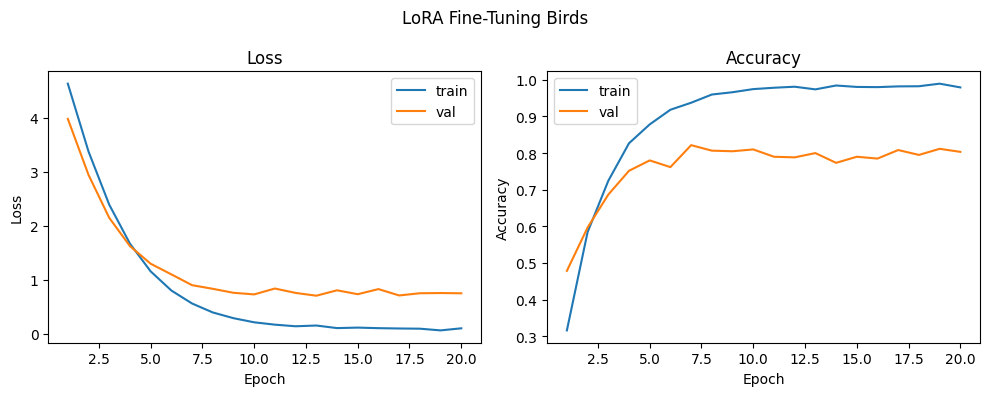

LoRA Test Loss: 0.7523 | Test Acc: 80.33%
Registered variant 'lora_birds' (dataset=cub_bird).
Saved variant 'lora_birds' to saved_variants/lora_birds
LoRA Birds finished


In [ ]:

print("--- Starting Method: LoRA Fine-Tuning Birds ---")

variant_backbone = None
variant_notes = "LoRA fine-tuning on CUB-200-2011"

if 'model' not in globals():
    model = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
    model.eval()


train_loader = cub_bird_train_loader if 'cub_bird_train_loader' in globals() else None
val_loader = cub_bird_val_loader if 'cub_bird_val_loader' in globals() else None
test_loader = cub_bird_test_loader if 'cub_bird_test_loader' in globals() else None
num_classes = len(cub_bird_class_names)

# Try to apply LoRA to the vision encoder. If PEFT is unavailable or fails, fall back to tuning the visual projection + head.
try:
    # load a fresh CLIP model to avoid interference
    model_lora = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
    variant_backbone = model_lora
    vision_model = model_lora.vision_model

    lora_config = LoraConfig(
        r=2,
        lora_alpha=4,
        target_modules=["q_proj", "v_proj", "k_proj"],
        lora_dropout=0.05,
        bias="none",
    )

    vision_model_lora = get_peft_model(vision_model, lora_config)
    model_lora.vision_model = vision_model_lora
    print("LoRA Model - Trainable Parameters:")
    vision_model_lora.print_trainable_parameters()

    # freeze visual projection and text encoder if present
    if hasattr(model_lora, 'visual_projection') and model_lora.visual_projection is not None:
        for p in model_lora.visual_projection.parameters():
            p.requires_grad = False

    # prepare head
    with torch.no_grad():
        dummy_px = processor(images=Image.new("RGB", (224, 224), "white"), return_tensors="pt")["pixel_values"].to(DEVICE)
        feat = model_lora.get_image_features(pixel_values=dummy_px)
        feat_dim = feat.shape[-1]
    head = nn.Linear(feat_dim, num_classes).to(DEVICE)

    params = list(filter(lambda p: p.requires_grad, model_lora.parameters())) + list(head.parameters())
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params, lr=5e-4)

    def eval_model(m):
        m.eval(); head.eval()
        total, correct, loss_sum = 0, 0, 0.0
        loader = val_loader if val_loader is not None else test_loader
        with torch.no_grad():
            for batch in loader:
                if isinstance(batch, dict):
                    imgs, labels = batch['pixel_values'], batch['label']
                else:
                    imgs, labels = batch
                if isinstance(imgs, list):
                    imgs = torch.stack(imgs, dim=0)
                imgs = imgs.to(DEVICE)
                labels = labels.to(DEVICE)
                feats = m.get_image_features(pixel_values=imgs)
                feats = feats / feats.norm(dim=-1, keepdim=True)
                logits = head(feats)
                loss = criterion(logits, labels)
                preds = logits.argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                loss_sum += loss.item() * labels.size(0)
        return loss_sum/total, correct/total

    # train LoRA + head (if train_loader exists)
    if train_loader is None:
        print('No training loader available for LoRA path; running quick eval instead')
        tloss, tacc = eval_model(model_lora)
        print(f"Val/Test Loss: {tloss:.4f} | Acc: {tacc*100:.2f}%")
    else:
        train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
        for epoch in range(NUM_EPOCHS):
            model_lora.train(); head.train()
            running_loss = 0.0
            running_correct = 0
            seen = 0
            for batch in tqdm(train_loader, desc=f"LoRA Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
                if isinstance(batch, dict):
                    imgs, labels = batch['pixel_values'], batch['label']
                else:
                    imgs, labels = batch
                if isinstance(imgs, list):
                    imgs = torch.stack(imgs, dim=0)
                imgs = imgs.to(DEVICE)
                labels = labels.to(DEVICE)
                feats = model_lora.get_image_features(pixel_values=imgs)
                feats = feats / feats.norm(dim=-1, keepdim=True)
                logits = head(feats)
                preds = logits.argmax(dim=-1)
                loss = criterion(logits, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * labels.size(0)
                running_correct += (preds == labels).sum().item()
                seen += labels.size(0)
            train_loss = running_loss / max(1, seen)
            train_acc = running_correct / max(1, seen)
            val_loss, val_acc = eval_model(model_lora)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            print(f"LoRA Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
        save_training_artifacts("finetuning_birds", "LoRA Fine-Tuning Birds", train_losses, train_accuracies, val_losses, val_accuracies)
        test_loss, test_acc = eval_model(model_lora)
        print(f"LoRA Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

except Exception as e:
    print("LoRA path failed or PEFT not available; falling back to tuning visual projection + head. Error:", e)
    # fallback approach
    model_fb = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
    variant_backbone = model_fb
    variant_notes = "Fallback fine-tuning on CUB-200-2011"
    if hasattr(model_fb, 'visual_projection') and model_fb.visual_projection is not None:
        for p in model_fb.visual_projection.parameters():
            p.requires_grad = True
    for p in model_fb.vision_model.parameters():
        p.requires_grad = False
    with torch.no_grad():
        dummy_px = processor(images=Image.new("RGB", (224, 224), "white"), return_tensors="pt")["pixel_values"].to(DEVICE)
        feat = model_fb.get_image_features(pixel_values=dummy_px)
        feat_dim = feat.shape[-1]
    head = nn.Linear(feat_dim, num_classes).to(DEVICE)
    optimizer = torch.optim.Adam(list(head.parameters()) + list(filter(lambda p: p.requires_grad, model_fb.parameters())), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    if train_loader is None:
        print('No training loader available for fallback; exiting fallback')
    else:
        fallback_train_losses, fallback_train_accuracies = [], []
        for epoch in range(NUM_EPOCHS):
            model_fb.train(); head.train()
            running_loss = 0.0
            running_correct = 0
            seen = 0
            for batch in tqdm(train_loader, desc=f"Fallback Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
                if isinstance(batch, dict):
                    imgs, labels = batch['pixel_values'], batch['label']
                else:
                    imgs, labels = batch
                if isinstance(imgs, list):
                    imgs = torch.stack(imgs, dim=0)
                imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
                feats = model_fb.get_image_features(pixel_values=imgs)
                feats = feats / feats.norm(dim=-1, keepdim=True)
                logits = head(feats)
                preds = logits.argmax(dim=-1)
                loss = criterion(logits, labels)
                optimizer.zero_grad(); loss.backward(); optimizer.step()
                running_loss += loss.item()*labels.size(0)
                running_correct += (preds == labels).sum().item()
                seen += labels.size(0)
            train_loss = running_loss / max(1, seen)
            train_acc = running_correct / max(1, seen)
            fallback_train_losses.append(train_loss)
            fallback_train_accuracies.append(train_acc)
            print(f"Fallback epoch {epoch+1} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        save_training_artifacts("finetuning_birds", "Fallback Fine-Tuning Birds", fallback_train_losses, fallback_train_accuracies)
        # Evaluate fallback
        def eval_fb():
            head.eval(); model_fb.eval()
            total, correct = 0, 0
            loader = val_loader if val_loader is not None else test_loader
            with torch.no_grad():
                for batch in loader:
                    if isinstance(batch, dict):
                        imgs, labels = batch['pixel_values'], batch['label']
                    else:
                        imgs, labels = batch
                    if isinstance(imgs, list):
                        imgs = torch.stack(imgs, dim=0)
                    imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
                    feats = model_fb.get_image_features(pixel_values=imgs)
                    feats = feats / feats.norm(dim=-1, keepdim=True)
                    preds = head(feats).argmax(dim=-1)
                    correct += (preds == labels).sum().item(); total += labels.size(0)
            return correct/total
        print(f"Fallback Val Acc: {eval_fb()*100:.2f}%")

if variant_backbone is not None:
    register_trained_variant(
        name="lora_birds",
        dataset="cub_bird",
        backbone=variant_backbone,
        head=head,
        baseline=model,
        notes=variant_notes
    )
print('LoRA Birds finished')


free_gpu_safe()


In [ ]:
# LoRA 微調後（CUB-200-2011）的預測比較
save_prediction_comparison_grid(
    "lora_birds",
    dataset="cub_bird",
    num_images=16,
    indices=[25, 45, 123, 125, 128, 129, 140, 143, 887, 888, 1384, 1385, 2985, 4010, 5569, 5570],
    split="test",
    cols=4,
    top_k=5,
    output_path="./data/fine_birds_result.png",
)


/tmp/ipykernel_1220719/3945290448.py:138: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.18, hspace=0.28)


Saved comparison grid to ./data/fine_birds_result.png


In [ ]:
free_gpu_safe()